In [1]:
import os
import numpy as np
import copy
import bpy
import matplotlib.pyplot as plt
import warnings
import colorsys
import math
import skimage
import torch
import xml.etree.ElementTree as ET

from shapely.geometry import Polygon
from matplotlib.lines import Line2D
from collections import OrderedDict
from torch_geometric.data import Data

/home/ivy8792/anaconda3/envs/bpy/lib/python3.10/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ivy8792/anaconda3/envs/bpy/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/ivy8792/anaconda3/envs/bpy/lib/python3.10/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ivy8792/anaconda3/envs/bpy/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
# import file
file_path = "./datasets/svg/011-library.svg"
# file_path = "./datasets/svg/053-weather.svg"
file_path = "./datasets/svg/020-cloudy-20230124.svg"

# clean the scene
bpy.ops.object.select_all()
bpy.ops.object.delete()
for curve in bpy.data.curves:
    bpy.data.curves.remove(curve)
for mesh in bpy.data.meshes:
    bpy.data.meshes.remove(mesh)

bpy.ops.import_curve.svg(filepath=file_path)

{'FINISHED'}

In [3]:
# # get width and height
# tree = ET.parse(file_path)
# root = tree.getroot()
# width = int(root.attrib["width"].strip("px"))
# height = int(root.attrib["height"].strip("px"))
# print(width, height)

In [4]:
mesh_colors = []
for ob in bpy.data.objects:
    if ob.type == "CURVE":
        try:
            mesh = bpy.data.meshes.new_from_object(ob)
            new_obj = bpy.data.objects.new("temp_mesh", mesh)
            
            c = new_obj.material_slots[0].material.diffuse_color
            mesh_colors.append([c[0], c[1], c[2]])
        except:
            mesh_colors.append([0.0, 0.0, 0.0])

In [5]:
curves = bpy.data.curves
paths = {
    path: {
        "id": None,
        "rgb": [],
        "path": []
    } for path in range(len(curves))
}

for i, (curve, rgb) in enumerate(zip(curves, mesh_colors)):
    paths[i]['id'] = i
    paths[i]['rgb'] = rgb

    p = []
    for spline in curve.splines:
        for j, bezier in enumerate(spline.bezier_points):
            start = list(bezier.co[:2])
            control1 = list(bezier.handle_left[:2])
            control2 = list(bezier.handle_right[:2])
            if j < len(spline.bezier_points) - 1:
                end = list(spline.bezier_points[j+1].co[:2])
            else:
                end = list(spline.bezier_points[0].co[:2])
            p.append([start, control1, control2, end])
    paths[i]['path'] = np.array(p)

In [6]:
edges = []
edge_attrs = []
edges_control = []
poss = []
colors = []
stroke_widths = []
is_control = []
color = [0.0, 0.0, 0.0]
stroke = 1

lab = []
cluster = []

idx = 0
for path in paths.values():
    rgb = path['rgb']
    l, a, b = np.array(skimage.color.rgb2lab(path['rgb']))
    l, a, b = l/100, (a+128)/256, (b+128)/256
    
    points = path['path']
    for start, control1, control2, end in points:
        cluster.append(path['id'])
        lab.append([l, a, b])
        
        poss.append(start)
        colors.append(color)
        stroke_widths.append(stroke)
        is_control.append(0)
        
        idx_control1 = idx + 1
        poss.append(control1)
        colors.append(color)
        stroke_widths.append(stroke)
        is_control.append(1)
        
        idx_control2 = idx + 2
        poss.append(control2)
        colors.append(color)
        stroke_widths.append(stroke)
        is_control.append(1)
        
        idx_end = idx + 3
        poss.append(end)
        colors.append(color)
        stroke_widths.append(stroke)
        is_control.append(0)
        
        euc_d2 = (start[0] - end[0]) * (start[0] - end[0]) + (start[1] - end[1]) * (start[1] - end[1])
        angle = (start[0] - end[0]) / (np.sqrt(euc_d2) + 1e-7)
        w = 1 / np.exp(euc_d2)
        
        edges.append([idx, idx_end])
        edges_control.append([idx, idx_control1])
        edges_control.append([idx, idx_control2])
        edges_control.append([idx_end, idx_control2])
        edges_control.append([idx_end, idx_control1])
        edges_control.append([idx_control1, idx_control2])
        
        edge_attrs.append([control1[0] - start[0], 
                control1[1] - start[1], 
                control2[0] - end[0], 
                control2[1] - end[1], 
                angle, 
                euc_d2])
        
        idx += 4
        
        # return {'pos':{'spatial': poss}, 
        #     'attr':{'color': colors, 'stroke_width': stroke_widths, 'is_control':is_control}, 
        #     'edge': {'shape':edges, 'control': edges_control}, 
        #     'edge_attr':{'shape': edge_attrs}
        # }

In [7]:
x = []
edge_index = []
edge_attr = []
rgb = []
lab = []
cluster = []
idx = 0

for path in paths.values():
    # rgb, lab, and cluster
    points = path['path']
    cluster += [path['id']] * points.shape[0]
    rgb += [path['rgb']] * points.shape[0]
    l, a, b = np.array(skimage.color.rgb2lab(path['rgb']))
    l, a, b = l/100, (a+128)/256, (b+128)/256
    lab += [[l, a, b]] * points.shape[0]
    
    # x, edge_index, and edge_attr
    _start = idx
    for i, (start, control1, control2, end) in enumerate(points):
        x.append(start)
        
        if i == len(points)-1:
            edge_index.append([idx, _start])
            edge_index.append([_start, idx])
        else:
            edge_index.append([idx, idx+1])
            edge_index.append([idx+1, idx])
        idx += 1
        
        # edge_attr: [control1_x, control1_y, control2_x, control2_y,
        #             control1_x-start_x, control1_y-start_y, control2_x-end_x,  control2_y-end_y, distance, angle]
        distance = (start[0] - end[0])**2 + (start[1] - end[1])**2
        angle = math.atan2(end[1] - start[1], end[0] - start[0])
        attr = [control1[0], control1[1], control2[0], control2[1]]
        attr += [control1[0]-start[0], control1[1]-start[1], control2[0]-end[0], control2[1]-end[1], distance, angle]
        edge_attr.append(attr)
        angle = math.atan2(start[1] - end[1], start[0] - end[0])
        attr = [control2[0], control2[1], control1[0], control1[1]]
        attr += [control2[0]-end[0], control2[1]-end[1], control1[0]-start[0], control1[1]-start[1], distance, angle]
        edge_attr.append(attr)

In [8]:
_x = torch.Tensor(np.array(x))
_edge_index = torch.Tensor(np.transpose(np.array(edge_index))).type(torch.long)
_edge_attr = torch.Tensor(np.array(edge_attr))
_rgb = torch.Tensor(np.array(rgb))
_lab = torch.Tensor(np.array(lab))
_cluster = torch.Tensor(cluster).type(torch.long)

data = Data(x=_x,
            edge_index=_edge_index,
            edge_attr=_edge_attr,
            rgb=_rgb,
            lab=_lab,
            cluster=_cluster,)

print(data)

Data(x=[25, 2], edge_index=[2, 50], edge_attr=[50, 10], rgb=[25, 3], lab=[25, 3], cluster=[25])


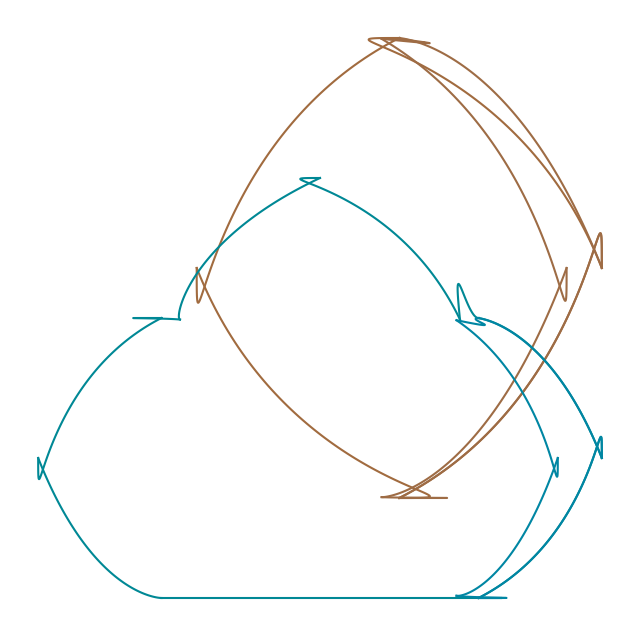

In [9]:
fig = plt.figure("plot", figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
plt.axis("off")

def bezier_curve(t, start, control1, control2, end):
    return (1-t)**3 * start + 3*(1-t)**2 * t * control1 + 3*(1-t) * t**2 * control2 + t**3 * end

lab = np.array(lab)
edge_attr = np.array(edge_attr)
for i, ((n1, n2), (c1x, c1y, c2x, c2y)) in enumerate(zip(edge_index, edge_attr[:,:4])):
    if n1 > n2: continue
    
    a, b = lab[n1, 1:]
    a, b = float(a*256-128), float(b*256-128)
    r, g, b = skimage.color.lab2rgb([50, a, b])
    x1, y1 = x[n1]
    x2, y2 = x[n2]
    t = np.linspace(0, 1, num=100)
    xx = [bezier_curve(j, x1, c1x, c2x, x2) for j in t]
    yy = [bezier_curve(j, y1, c1y, c2y, y2) for j in t]
    plt.plot(xx, yy, color=[r, g, b])
plt.show()